# Processing of scDNA data

In [1]:
import warnings
warnings.filterwarnings('ignore')
import glob
import sys

import anndata as ad
import infercnvpy as cnv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from muon import atac as ac
from muon._atac import tools as tools
import muon as mu

sys.path.insert(1, '../helper_functions')
from helper_functions import prepare_counts_df, gini, lorenz, prepare_cnvs

The main input for this notebook are .seg files produced from bam processing. In this example, we use 1000kb bin size counts. 

In [2]:
all_count_files = glob.glob("../../HIPSDR-seq/readCount_filtered_bam/*1000kb*.seg")

### Read seg files and prepare a dataframe cell x bin

In [3]:
counts_df_orig = prepare_counts_df(all_count_files, binsize=1000000)

100%|██████████| 7847/7847 [00:00<00:00, 841154.76it/s]


recording


In [4]:
counts_df_orig

,chr1:1-1000001,chr1:1000001-2000001,chr1:2000001-3000001,chr1:3000001-4000001,chr1:4000001-5000001,chr1:5000001-6000001,chr1:6000001-7000001,chr1:7000001-8000001,chr1:8000001-9000001,chr1:9000001-10000001,...,chrY:48000001-49000001,chrY:49000001-50000001,chrY:50000001-51000001,chrY:51000001-52000001,chrY:52000001-53000001,chrY:53000001-54000001,chrY:54000001-55000001,chrY:55000001-56000001,chrY:56000001-57000001,chrY:57000001-58000001
GATTACGGTCATTGAG-1,14,4,4,2,4,6,8,6,2,2,...,0,0,0,0,0,0,0,0,0,0
GGAGTCTGTAATCGGC-1,0,0,2,2,4,0,6,4,0,0,...,0,0,0,0,0,0,0,0,0,0
TTCAGGTAGTAAGAAC-1,10,18,46,40,55,36,54,53,45,22,...,0,0,0,0,0,0,0,0,2,0
TGCAGGCTCGGTTTGG-1,14,46,42,42,46,38,36,44,50,56,...,0,0,0,0,0,0,0,0,4,0
AGGACTAAGGCCTTAG-1,0,0,0,0,0,0,0,2,2,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTTTATCAGCTAAGTC-1,0,4,2,6,0,4,4,10,6,4,...,0,0,0,0,0,0,0,0,0,0
GAAGTATAGACTATTG-1,8,40,30,50,34,48,64,68,48,34,...,0,0,0,0,0,0,0,0,2,0
AGGACTAAGTTAGTGC-1,4,0,0,0,2,4,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
AACCTTGCAGGACCAA-1,2,8,12,14,28,14,2,14,10,6,...,0,0,0,0,0,0,0,0,0,0


In [5]:
counts_df_orig.to_csv("../data/HIPSDR_DNA_counts_raw.csv.gz")

## Compute some basic QC parameters

In [6]:
gini_matac = counts_df_orig.apply(lambda row: gini(row), axis=1).values
lorenz_matac = counts_df_orig.apply(lambda row: lorenz(row), axis=1).values
lorenz_matac_2d = np.array([np.array(x) for x in lorenz_matac])

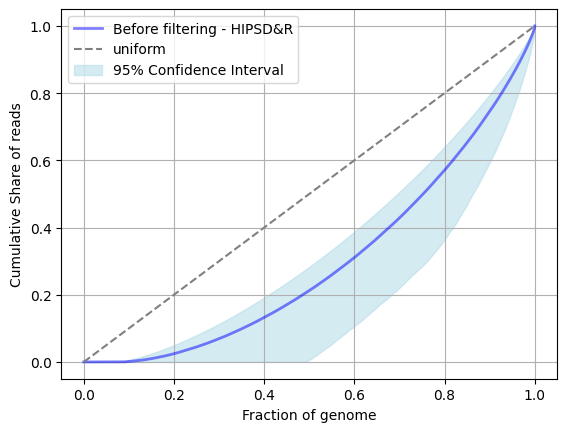

In [7]:
median_lorenz = np.median(lorenz_matac_2d, axis=0)
lower_bound = np.percentile(lorenz_matac_2d, 2.5, axis=0)
upper_bound = np.percentile(lorenz_matac_2d, 97.5, axis=0)

x_values = np.arange(len(median_lorenz)) / (len(median_lorenz) - 1)

plt.plot(
    x_values,
    median_lorenz,
    label="Before filtering - HIPSD&R",
    lw=2,
    color="blue",
    alpha=0.5,
)
plt.plot(x_values, x_values, label="uniform", ls="--", color="grey")
plt.fill_between(x_values, lower_bound, upper_bound, color='lightblue', alpha=0.5, label='95% Confidence Interval')

plt.xlabel("Fraction of genome")
plt.ylabel("Cumulative Share of reads")
plt.legend()
plt.grid(True)

Text(0, 0.5, 'Count')

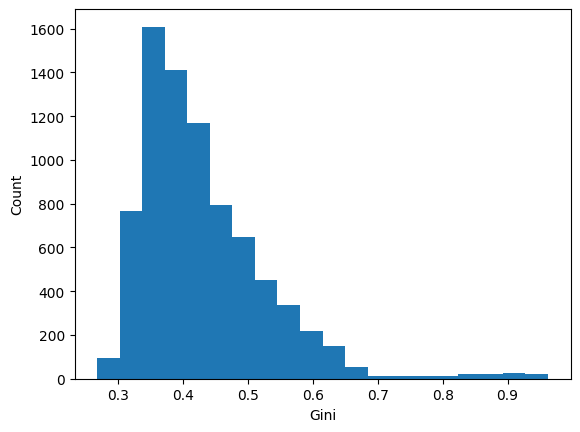

In [8]:
plt.hist(gini_matac, bins=20)
plt.xlabel("Gini")
plt.ylabel("Count")

In [9]:
# Read count dataframe with anndata to make all the processing easier
atac = ad.AnnData(counts_df_orig)

In [10]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

In [11]:
atac.obs.rename(
    columns={
        "n_genes_by_counts": "n_features_per_cell",
    },
    inplace=True,
)

In [12]:
atac.obs["log_total_counts"] = np.log10(atac.obs["total_counts"])

To estimate the efficiency of nucleosome depletion, we will compute nucleosome signal, TSS score enrichment and fragment length distribution.
First we need to locate the fragment file output from cellranger.

In [13]:
ac.tl.locate_fragments(
    atac, "../../HIPSDR-seq/1_LFS_HIPSDR_DNA_2/../1_LFS_HIPSDR_multiome_2/outs/atac_fragments.tsv.gz"
)

In [14]:
ac.tl.nucleosome_signal(atac)

Reading Fragments: 100%|██████████| 78470000/78470000 [04:45<00:00, 275235.25it/s]


(0.0, 2.0)

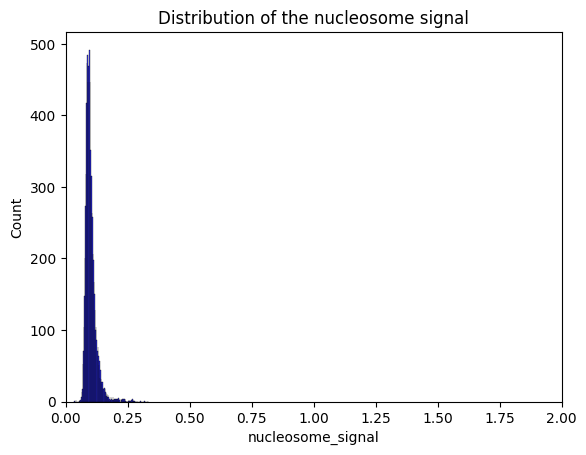

In [15]:
sns.histplot(atac.obs, x="nucleosome_signal", color="blue")
plt.title("Distribution of the nucleosome signal")
plt.xlim((0, 2))

In [16]:
path = "../../HIPSDR-seq/1_LFS_HIPSDR_DNA_2/../1_LFS_HIPSDR_multiome_2/outs/filtered_feature_bc_matrix.h5"
mdata = mu.read_10x_h5(path)

Added `interval` annotation for features from ../../HIPSDR-seq/1_LFS_HIPSDR_DNA_2/../1_LFS_HIPSDR_multiome_2/outs/filtered_feature_bc_matrix.h5
Added peak annotation from ../../HIPSDR-seq/1_LFS_HIPSDR_DNA_2/../1_LFS_HIPSDR_multiome_2/outs/atac_peak_annotation.tsv to .uns['atac']['peak_annotation']
Added gene names to peak annotation in .uns['atac']['peak_annotation']
Located fragments file: ../../HIPSDR-seq/1_LFS_HIPSDR_DNA_2/../1_LFS_HIPSDR_multiome_2/outs/atac_fragments.tsv.gz


In [17]:
mdata.var_names_make_unique()

In [18]:
from muon._rna.utils import get_gene_annotation_from_rna
features_rna = get_gene_annotation_from_rna(mdata.mod["rna"])
features_rna.to_csv("rna_features.csv")

In [19]:
# We need to map the location of reads to genes to calculate TSS score enrichment
features = pd.read_csv(
    "rna_features.csv",
    index_col=0,
)
features = features.loc[~features.Start.isnull()]
features.Start = features.Start.astype(int)
features.End = features.End.astype(int)

In [20]:
tss = ac.tl.tss_enrichment(atac, n_tss=100000, random_state=666, features=features)

Fetching Regions...: 100%|██████████| 36588/36588 [01:40<00:00, 363.05it/s]


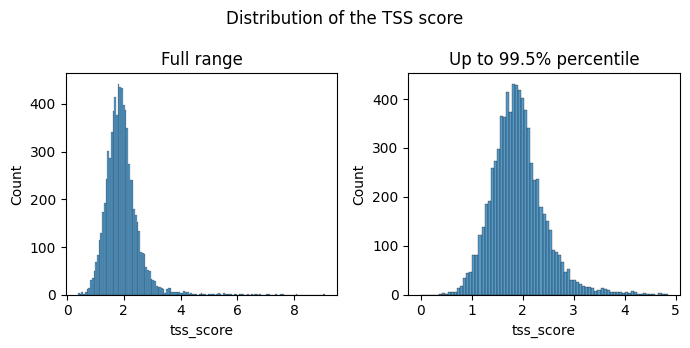

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3.5))

p1 = sns.histplot(atac.obs, x="tss_score", ax=axs[0])
p1.set_title("Full range")

p2 = sns.histplot(
    atac.obs,
    x="tss_score",
    binrange=(0, atac.obs["tss_score"].quantile(0.995)),
    ax=axs[1],
)
p2.set_title("Up to 99.5% percentile")

plt.suptitle("Distribution of the TSS score")

plt.tight_layout()

In [22]:
# Compute fragment length and coverage
region = "chr1:1-248956422"
hg_size = 3099706404

fragment_path = atac.uns["files"]["fragments"]
fragments = tools.fetch_regions_to_df(fragment_path=fragment_path, features=region)

fragments["length"] = fragments.End - fragments.Start
fragments.set_index(keys="Cell", inplace=True)
fragments = fragments.join(atac.obs, how="right")
f_length = fragments.length.median()
atac.obs["coverage"] = (atac.obs["total_counts"] * f_length) / hg_size

Fetching Regions...: 100%|██████████| 1/1 [02:13<00:00, 133.84s/it]


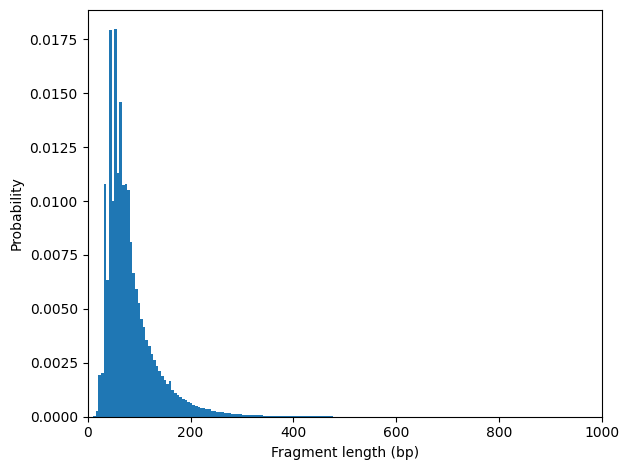

In [23]:
plt.hist(x=fragments["length"], bins=1000, density=True)
plt.xlim((0, 1000))
plt.xlabel("Fragment length (bp)")
plt.ylabel("Probability")
plt.tight_layout()

In [24]:
atac.obs["gini"] = gini_matac

In [25]:
atac.write("hipsdr_processed.h5ad")

In [26]:
atac = sc.read_h5ad("hipsdr_processed.h5ad")
atac

AnnData object with n_obs × n_vars = 7847 × 3102
    obs: 'n_features_per_cell', 'total_counts', 'log_total_counts', 'nucleosome_signal', 'tss_score', 'coverage', 'gini'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'files'

## Computing CNAs
At this point you can run HMMCopy script on all the cells. After that come back to this notebook, where we will do some initial plotting as well as removing poor quality cells.

In [27]:
all_cnv_files = glob.glob("../../HIPSDR-seq/HMMcopy_1MB_updated/*per_bin_calls_long.bed")
len(all_cnv_files)

7838

In [28]:
cna = prepare_cnvs(all_cnv_files)

100%|██████████| 7838/7838 [02:31<00:00, 51.64it/s] 


If the coverage of a cell is really low, HMMCopy might fail so the number of cells here might not be exactly the same as above.

Since our methods provides high throughput, but low coverage, we noticed that poor quality cells are mainly defined by the low number of non-empty genomic bins. In other words, we want to remove cells with high number of bins without any read counts as you obviously cannot reliably call CNAs on them.

In [29]:
cna

bin,chr1:1-1000001,chr1:1000001-2000001,chr1:2000001-3000001,chr1:3000001-4000001,chr1:4000001-5000001,chr1:5000001-6000001,chr1:6000001-7000001,chr1:7000001-8000001,chr1:8000001-9000001,chr1:9000001-10000001,...,chrY:48000001-49000001,chrY:49000001-50000001,chrY:50000001-51000001,chrY:51000001-52000001,chrY:52000001-53000001,chrY:53000001-54000001,chrY:54000001-55000001,chrY:55000001-56000001,chrY:56000001-57000001,chrY:57000001-58000001
TGTGATCAGAACAAGT-1,5,5,5,5,5,5,5,5,5,5,...,3,3,3,3,3,3,3,3,3,3
CCCTTAATCAGCAAAG-1,4,4,4,4,4,4,4,4,4,4,...,3,3,3,3,3,3,3,3,3,3
GTTTGTTTCATGGCCA-1,2,2,2,2,2,2,2,2,2,2,...,3,3,3,3,3,3,3,3,3,3
TTTCGTCCAGCCAGTT-1,4,4,4,4,4,4,4,4,4,4,...,3,3,3,3,3,3,3,3,3,3
CGGTAACGTATTCGTC-1,4,4,4,4,4,4,4,4,4,4,...,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCTAACCGTAACCACA-1,4,4,4,4,4,4,4,4,4,4,...,3,3,3,3,3,3,3,3,3,3
TACCGCAAGCTATATG-1,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
TATTAGGTCCGCAACA-1,5,5,5,5,5,5,5,5,5,5,...,3,3,3,3,3,3,3,3,3,3
TGCGATTAGGTGTCCA-1,1,1,1,1,1,1,1,3,3,3,...,3,3,3,3,3,3,3,3,3,3


In [30]:
# The threshold of 0.9 worked well in our case, but it might not be ideal for your case
cna = cna.loc[atac[atac.obs["n_features_per_cell"] > 0.9 * len(atac.var)].obs_names]
# We subtract 1 from our data, since HMMcopy reports the copy number as values CN + 1
cna = cna - 1
# We will also replace all 0s with 1s, as we noticed that with HMMcopy
# we could not distinguish homozygous and heterozygous deletions
cna.replace(0, 1, inplace=True)
cna

bin,chr1:1-1000001,chr1:1000001-2000001,chr1:2000001-3000001,chr1:3000001-4000001,chr1:4000001-5000001,chr1:5000001-6000001,chr1:6000001-7000001,chr1:7000001-8000001,chr1:8000001-9000001,chr1:9000001-10000001,...,chrY:48000001-49000001,chrY:49000001-50000001,chrY:50000001-51000001,chrY:51000001-52000001,chrY:52000001-53000001,chrY:53000001-54000001,chrY:54000001-55000001,chrY:55000001-56000001,chrY:56000001-57000001,chrY:57000001-58000001
TTCAGGTAGTAAGAAC-1,4,4,4,4,4,4,4,4,4,4,...,2,2,2,2,2,2,2,2,2,2
TGCAGGCTCGGTTTGG-1,4,4,4,4,4,4,4,4,4,4,...,1,1,1,1,1,1,1,1,1,1
CCTTATGTCTAGCGAT-1,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
TACTTCGTCGCCTAAG-1,4,4,4,4,4,4,4,4,4,4,...,1,1,1,1,1,1,1,1,1,1
AGGTATTGTAGGTTGC-1,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CAAACTGGTAACCACA-1,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
ACGCAAGCACGTTACA-1,3,3,3,3,3,3,3,3,3,3,...,2,2,2,2,2,2,2,2,2,2
AATCCGTAGGTTTACA-1,3,3,3,3,3,3,3,3,3,3,...,1,1,1,1,1,1,1,1,1,1
TCCCGTTAGCTCAAAC-1,1,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2


In [31]:
rna_barcodes = []
with open("../../cell_calling/HIPSDR_barcodes_rna.tsv") as fin:
    for line in fin:
        rna_barcodes.append(line.rstrip())

In [32]:
cna = cna.loc[[bar for bar in rna_barcodes if bar in cna.index], [col for col in cna.columns if not col.startswith("chrY")]].copy()

In [33]:
cna

bin,chr1:1-1000001,chr1:1000001-2000001,chr1:2000001-3000001,chr1:3000001-4000001,chr1:4000001-5000001,chr1:5000001-6000001,chr1:6000001-7000001,chr1:7000001-8000001,chr1:8000001-9000001,chr1:9000001-10000001,...,chrX:147000001-148000001,chrX:148000001-149000001,chrX:149000001-150000001,chrX:150000001-151000001,chrX:151000001-152000001,chrX:152000001-153000001,chrX:153000001-154000001,chrX:154000001-155000001,chrX:155000001-156000001,chrX:156000001-157000001
GGAGGTTAGGGCTTTG-1,2,2,2,2,2,2,2,2,2,2,...,4,4,4,4,4,4,4,4,4,4
ACAACACTCGACAAAG-1,1,1,1,1,1,1,1,1,1,1,...,1,1,2,2,2,2,2,2,2,2
AAGGTGCAGGAACCAA-1,2,2,2,2,2,2,2,2,2,2,...,1,1,1,1,1,1,1,1,1,1
TTAACCAAGGCTGGCT-1,5,5,5,5,5,5,5,5,5,5,...,2,2,4,4,4,4,4,4,4,4
TGAGCCGGTTAGTGAT-1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTCCATCAGCTGTCAG-1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
TTCTTAGGTCACAGAC-1,3,3,3,3,3,3,3,3,3,3,...,1,1,1,1,1,1,1,1,1,1
TATTTGGAGCACTTGG-1,2,2,2,2,2,2,2,2,2,2,...,1,1,1,1,1,1,1,1,1,1
TGTGCTGAGGTGCTGC-1,2,2,2,2,2,2,2,2,2,2,...,1,1,1,1,1,1,1,1,1,1


In [34]:
cna.to_csv("../data/CNVs_HIPSDR_filtered.csv.gz")

Lets read the dataframe with anndata

In [35]:
# Before creating anndata object, we will center the neutral state to 0, so
# that all values are between -1 and 1 
cna = (cna-2)/3
adata = sc.AnnData(cna)

In [36]:
# Adding QC data from above to the new anndata object
adata.obs = adata.obs.join(atac.obs)

In [37]:
# Preparing genomic features
adata.var["chromosome"] = adata.var.index.str.split(":").str[0]
adata.var["start"] = (
    adata.var.index.str.split(":").str[1].str.split("-").str[0].astype(int)
)
adata.var["end"] = (
    adata.var.index.str.split(":").str[1].str.split("-").str[1].astype(int)
)

In [38]:
adata.var

,chromosome,start,end
bin,,,
chr1:1-1000001,chr1,1,1000001
chr1:1000001-2000001,chr1,1000001,2000001
chr1:2000001-3000001,chr1,2000001,3000001
chr1:3000001-4000001,chr1,3000001,4000001
chr1:4000001-5000001,chr1,4000001,5000001
...,...,...,...
chrX:152000001-153000001,chrX,152000001,153000001
chrX:153000001-154000001,chrX,153000001,154000001
chrX:154000001-155000001,chrX,154000001,155000001


In [39]:
adata.var.columns = ["chromosome", "start", "end"]
adata.obsm["X_cnv"] = adata.X
adata.var["pos"] = np.arange(adata.var.shape[0])
chrom_dict = {}
chrom_dict["chr_pos"] = {}
for tup in adata.var.itertuples():
    if tup.chromosome not in chrom_dict["chr_pos"]:
        chrom_dict["chr_pos"][tup.chromosome] = tup.pos
    if chrom_dict["chr_pos"][tup.chromosome] > tup.pos:
        chrom_dict["chr_pos"][tup.chromosome] = tup.pos
adata.uns["cnv"] = chrom_dict

... storing 'chromosome' as categorical


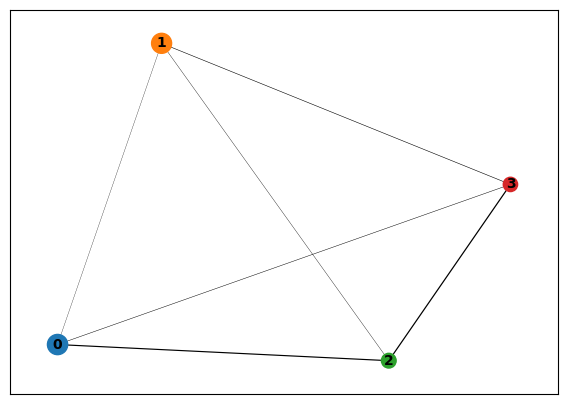

In [40]:
# Perform basic clustering
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata)
sc.tl.leiden(adata, key_added="cnv_leiden", resolution=0.5)
sc.tl.paga(adata, groups="cnv_leiden")
sc.pl.paga(
    adata, plot=True
)
sc.tl.umap(adata, init_pos="paga")

         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


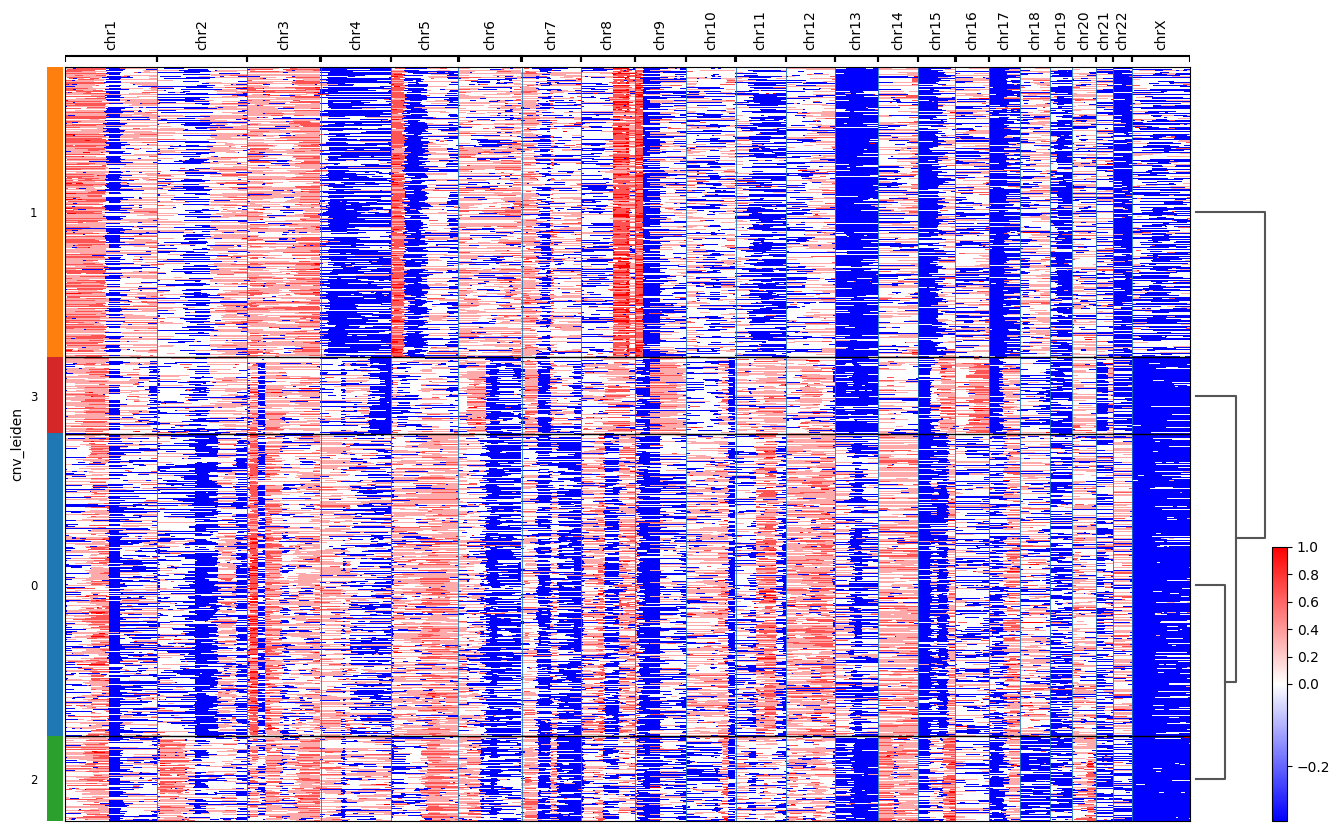

In [41]:
# Plot the heatmap with CNVs
cnv.pl.chromosome_heatmap(
    adata, groupby="cnv_leiden", dendrogram=True, figsize=(16, 10)
)

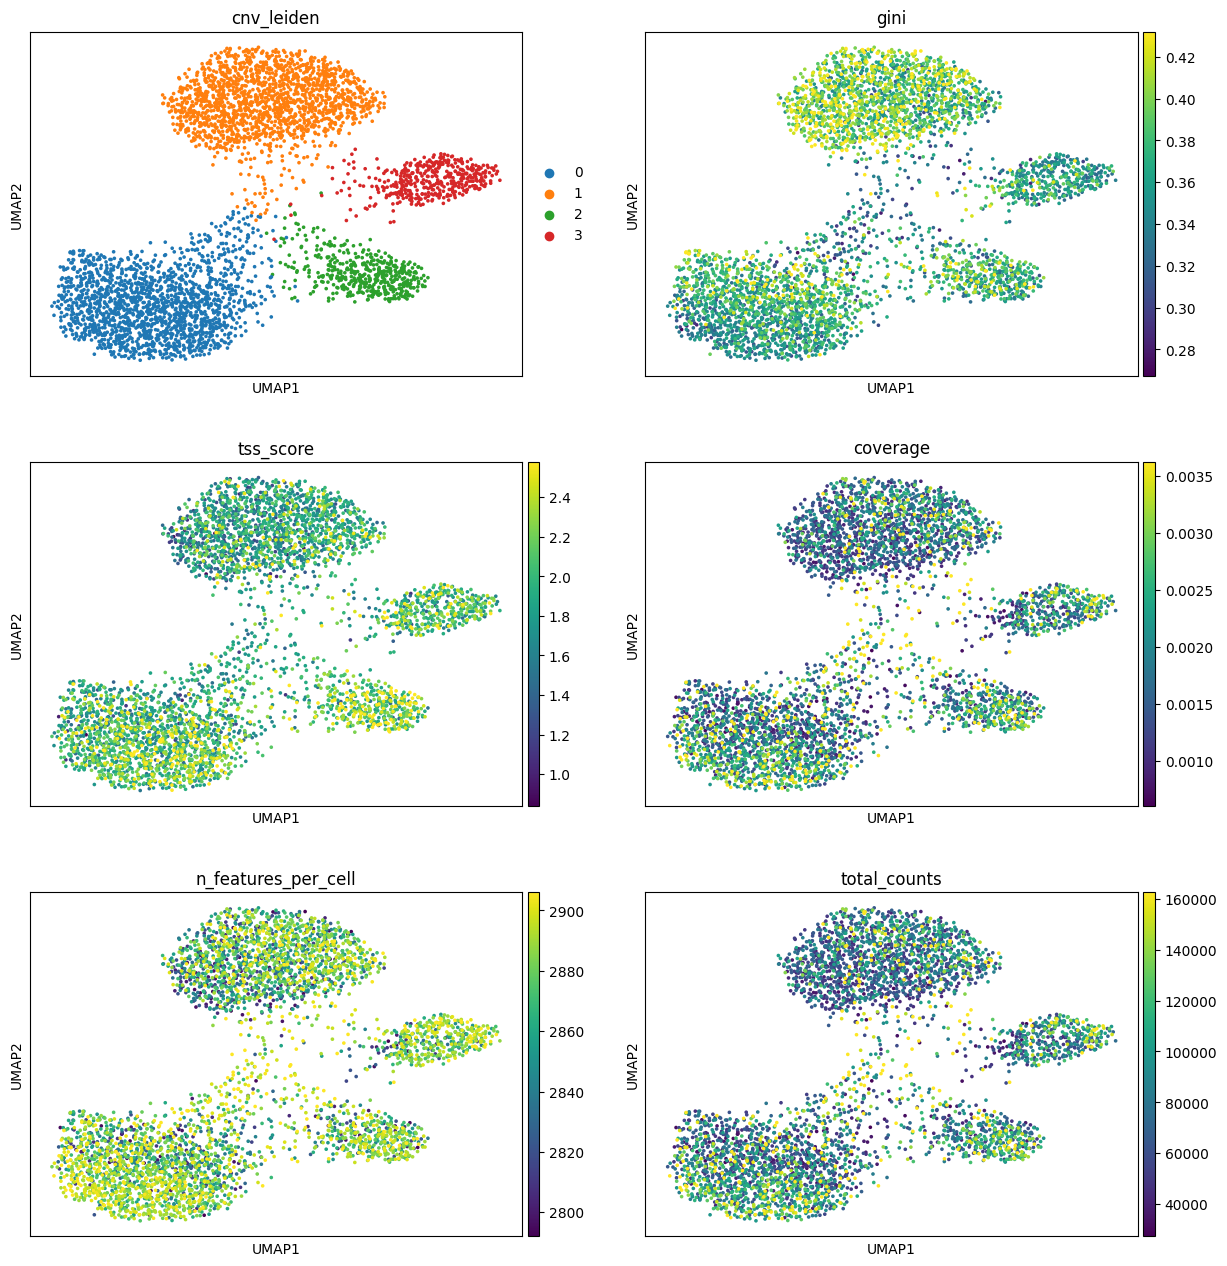

In [42]:
sc.pl.umap(
    adata,
    color=[
        "cnv_leiden",
        "gini",
        "tss_score",
        "coverage",
        "n_features_per_cell",
        "total_counts",
    ],
    ncols=2,
    vmax="p95",
)

From the heatmap and UMAP you will get an idea how CNV profiles look like and if any of the QC parameters is associated with noisy single-cell profile. Filter those cells accordingly.